## Setup

In [219]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [220]:
SILO_path = "/Users/phelps/PhD/DATA/climate/SILO/processed/flux_sites"
fluxdata_path ="/Users/phelps/PhD/DATA/ozflux/L6"

## Functions

In [221]:
def load_silo_site(ncfile):
    ds = xr.open_dataset(ncfile)

    # Drop lat/lon dimensions (they are length 1)
    ds = ds.squeeze(drop=True)

    # Convert time to datetime
    ds['time'] = pd.to_datetime(ds['time'].values)

    # Mask fill values
    for v in ds.data_vars:
        if '_FillValue' in ds[v].attrs:
            ds[v] = ds[v].where(ds[v] != ds[v].attrs['_FillValue'])

    return ds

def load_ozflux_site(ncfile):
    ds = xr.open_dataset(ncfile)

    # Convert time to datetime
    ds['time'] = pd.to_datetime(ds['time'].values)

    
    return ds

def daily_aggregate(ds):
    
    ds['Sws_95cma'] =ds['Sws_95cma'].where(ds['Sws_95cma'] >0)

    daily_rain = ds['Precip'].resample(time="1D").sum()
    max_temp = ds['Ta'].resample(time="1D").max()
    min_temp = ds['Ta'].resample(time="1D").min()
    radiation = ds['Fsd'].resample(time="1D").sum()
    Sws_10_avg = ds['Sws'].resample(time="1D").mean()
    Sws_95_avg = ds['Sws_95cma'].resample(time="1D").mean()
    
    return xr.Dataset({
        'daily_rain': daily_rain,
        'max_temp': max_temp,
        'min_temp': min_temp,
        'radiation': radiation,
        'Sws_10_avg': Sws_10_avg,
        'Sws_95_avg': Sws_95_avg
    })

def daily_climatology(ds, var):
    clim = (
        ds[var]
        .groupby("time.dayofyear")
        .mean("time")
    )
    clim_std = (
        ds[var]
        .groupby("time.dayofyear")
        .std("time")
    )

    clim_p90 = ds[var].groupby("time.dayofyear").quantile(0.9).reset_coords("quantile", drop=True)
    clim_p95 = ds[var].groupby("time.dayofyear").quantile(0.95).reset_coords("quantile", drop=True)
    clim_p10 = ds[var].groupby("time.dayofyear").quantile(0.1).reset_coords("quantile", drop=True)

    return clim, clim_std, clim_p10, clim_p90, clim_p95

def absolute_anomaly(ds, var, clim):
    return ds[var].groupby("time.dayofyear") - clim

def standardised_anomaly(ds, var, clim, clim_std):
    return (ds[var].groupby("time.dayofyear") - clim) / clim_std

def rolling_rain(ds, window):
    return ds["daily_rain"].rolling(time=window, min_periods=window).sum()


## Load data

In [222]:
ds_ozflux = load_ozflux_site(f"{fluxdata_path}/WombatStateForest_L6.nc")
ds_SILO = load_silo_site(f"{SILO_path}/wom_2000-2024.nc")

ds_ozflux_daily = daily_aggregate(ds_ozflux)

ds_SILO["rain_30dayTot"] = rolling_rain(ds_SILO, 30)
ds_SILO["rain_90dayTot"] = rolling_rain(ds_SILO, 90)

ds_ozflux_daily["rain_30dayTot"] = rolling_rain(ds_ozflux_daily, 30)
ds_ozflux_daily["rain_90dayTot"] = rolling_rain(ds_ozflux_daily, 90)

In [223]:
ds_SILO

<xarray.Dataset> Size: 402kB
Dimensions:        (time: 9132)
Coordinates:
  * time           (time) datetime64[ns] 73kB 2000-01-01 ... 2024-12-31
Data variables:
    daily_rain     (time) float32 37kB 0.1 -1.819e-13 ... -1.819e-13 -1.819e-13
    max_temp       (time) float32 37kB ...
    min_temp       (time) float32 37kB ...
    radiation      (time) float32 37kB ...
    rh_tmax        (time) float32 37kB ...
    rh_tmin        (time) float32 37kB ...
    vp_deficit     (time) float32 37kB ...
    rain_30dayTot  (time) float32 37kB nan nan nan nan ... 30.5 32.4 31.4 25.1
    rain_90dayTot  (time) float32 37kB nan nan nan nan ... 130.5 130.1 130.1
Attributes: (12/14)
    CDI:                      Climate Data Interface version 2.5.4 (https://m...
    Conventions:              CF-1.6
    institution:              Queensland Government, Department of Environmen...
    department:               Department of Environment and Science
    department_short:         DES
    copyright:                Copyright - the State of Queensland Department ...
    ...                       ...
    raster_source_additions:  and other suppliers (see the SILO webpage for d...
    metadata_url:             http://qldspatial.information.qld.gov.au/catalo...
    reference:                Jeffrey, S.J., Carter, J.O., Moodie, K.B.A. and...
    disclaimer:               1. The user accepts all responsibility and risk...
    history:                  Fri Nov 28 14:54:27 2025: cdo mergetime wom_200...
    CDO:                      Climate Data Operators version 2.5.4 (https://m...

## Climatology

In [207]:
CLIM_START = "2000-01-01"
CLIM_END   = "2018-12-31"

ds_SILO_clim_period = ds_SILO.sel(time=slice(CLIM_START, CLIM_END))
ds_ozflux_clim_period = ds_ozflux_daily.sel(time=slice(CLIM_START, CLIM_END))

rain_30dayTot_clim, rain_30dayTot_std,rain_30dayTot_p10 , rain_30dayTot_p90, _ = daily_climatology(ds_SILO_clim_period, "rain_30dayTot")
rain_90dayTot_clim, rain_90dayTot_std,rain_90dayTot_p10 , rain_90dayTot_p90, _ = daily_climatology(ds_SILO_clim_period, "rain_90dayTot")

ds_SILO_clim = xr.Dataset({
        'rain_30dayTot_clim': rain_30dayTot_clim,
        'rain_30dayTot_std': rain_30dayTot_std,
        'rain_30dayTot_p10': rain_30dayTot_p10,
        'rain_30dayTot_p90': rain_30dayTot_p90,
        'rain_90dayTot_clim': rain_90dayTot_clim,
        'rain_90dayTot_std': rain_90dayTot_std,
        'rain_90dayTot_p10': rain_90dayTot_p10,
        'rain_90dayTot_p90': rain_90dayTot_p90
    })

rain_30dayTot_clim, rain_30dayTot_std,rain_30dayTot_p10 , rain_30dayTot_p90, _ = daily_climatology(ds_ozflux_clim_period, "rain_30dayTot")
rain_90dayTot_clim, rain_90dayTot_std,rain_90dayTot_p10 , rain_90dayTot_p90, _ = daily_climatology(ds_ozflux_clim_period, "rain_90dayTot")

ds_ozflux_clim = xr.Dataset({
        'rain_30dayTot_clim': rain_30dayTot_clim,
        'rain_30dayTot_std': rain_30dayTot_std,
        'rain_30dayTot_p10': rain_30dayTot_p10,
        'rain_30dayTot_p90': rain_30dayTot_p90,
        'rain_90dayTot_clim': rain_90dayTot_clim,
        'rain_90dayTot_std': rain_90dayTot_std,
        'rain_90dayTot_p10': rain_90dayTot_p10,
        'rain_90dayTot_p90': rain_90dayTot_p90
    })

df_SILO_clim = ds_SILO_clim.to_dataframe().reset_index()
df_ozflux_clim = ds_ozflux_clim.to_dataframe().reset_index()

In [208]:
def smooth_doy_climatology(
    df,
    window=31,
    drop_feb29=False
):
    """
    Periodically smooth a day-of-year climatology DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        Indexed by dayofyear (1–365 or 1–366), columns = climatology stats
    window : int
        Odd window length for centered smoothing (default 31)
    drop_feb29 : bool
        Drop day 366 before smoothing (recommended)

    Returns
    -------
    pandas.DataFrame
        Smoothed climatology with same index and columns as input
    """

    if window % 2 == 0:
        raise ValueError("window must be odd for centered smoothing")

    df = df.sort_index()

    if drop_feb29 and 366 in df.index:
        df = df.drop(366)

    half = window // 2

    # periodic extension
    df_ext = pd.concat([
        df.iloc[-half:],
        df,
        df.iloc[:half]
    ])

    # centered rolling mean
    df_smooth_ext = df_ext.rolling(
        window=window,
        center=True,
        min_periods=window
    ).mean()

    # trim back to original year
    df_smooth = df_smooth_ext.iloc[half:-half]
    df_smooth.index = df.index

    return df_smooth


In [209]:
df = df_SILO_clim.set_index('dayofyear')
df_SILO_clim_smooth = smooth_doy_climatology(df, window=31, drop_feb29=False)

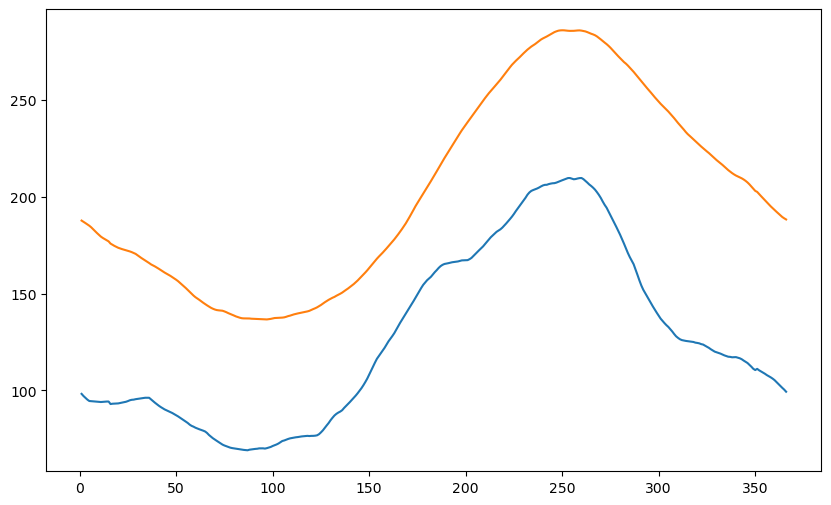

In [211]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_SILO_clim_smooth.index, df_SILO_clim_smooth['rain_90dayTot_p10'])
ax.plot(df_SILO_clim_smooth.index, df_SILO_clim_smooth['rain_90dayTot_clim'])

In [212]:
df_SILO_clim_smooth.head()

,rain_30dayTot_clim,rain_30dayTot_std,rain_30dayTot_p10,rain_30dayTot_p90,rain_90dayTot_clim,rain_90dayTot_std,rain_90dayTot_p10,rain_90dayTot_p90
dayofyear,,,,,,,,
1,54.965338,32.269346,18.585561,94.858478,187.666833,72.735799,98.261875,262.550527
2,54.525233,32.282479,18.546209,93.436542,187.052326,73.026165,97.144459,260.455687
3,53.980826,32.261661,18.581372,91.973316,186.373604,73.272366,96.192521,258.124720
4,53.414640,32.199545,18.552019,90.556217,185.683130,73.510798,95.288648,255.910526
5,52.909773,32.162850,18.486537,89.170088,185.017916,73.793209,94.574456,253.919557


In [213]:
df_ozflux = ds_ozflux_daily.to_dataframe().reset_index()
df_ozflux['dayofyear'] = df_ozflux['time'].dt.dayofyear

df_merged = pd.merge(
    df_SILO_clim_smooth.reset_index(),
    df_ozflux,
    on="dayofyear",
    suffixes=("_SILO_clim_smooth", "_ozflux")
)

In [214]:
df_merged = df_merged.set_index('time').sort_index()

In [215]:
df_merged['drought_30'] = df_merged['rain_30dayTot'] < df_merged['rain_30dayTot_p10']
df_merged['excess_30'] = df_merged['rain_30dayTot'] > df_merged['rain_30dayTot_p90']
df_merged['drought_90'] = df_merged['rain_90dayTot'] < df_merged['rain_90dayTot_p10']
df_merged['excess_90'] = df_merged['rain_90dayTot'] > df_merged['rain_90dayTot_p90']

## 30 day drought

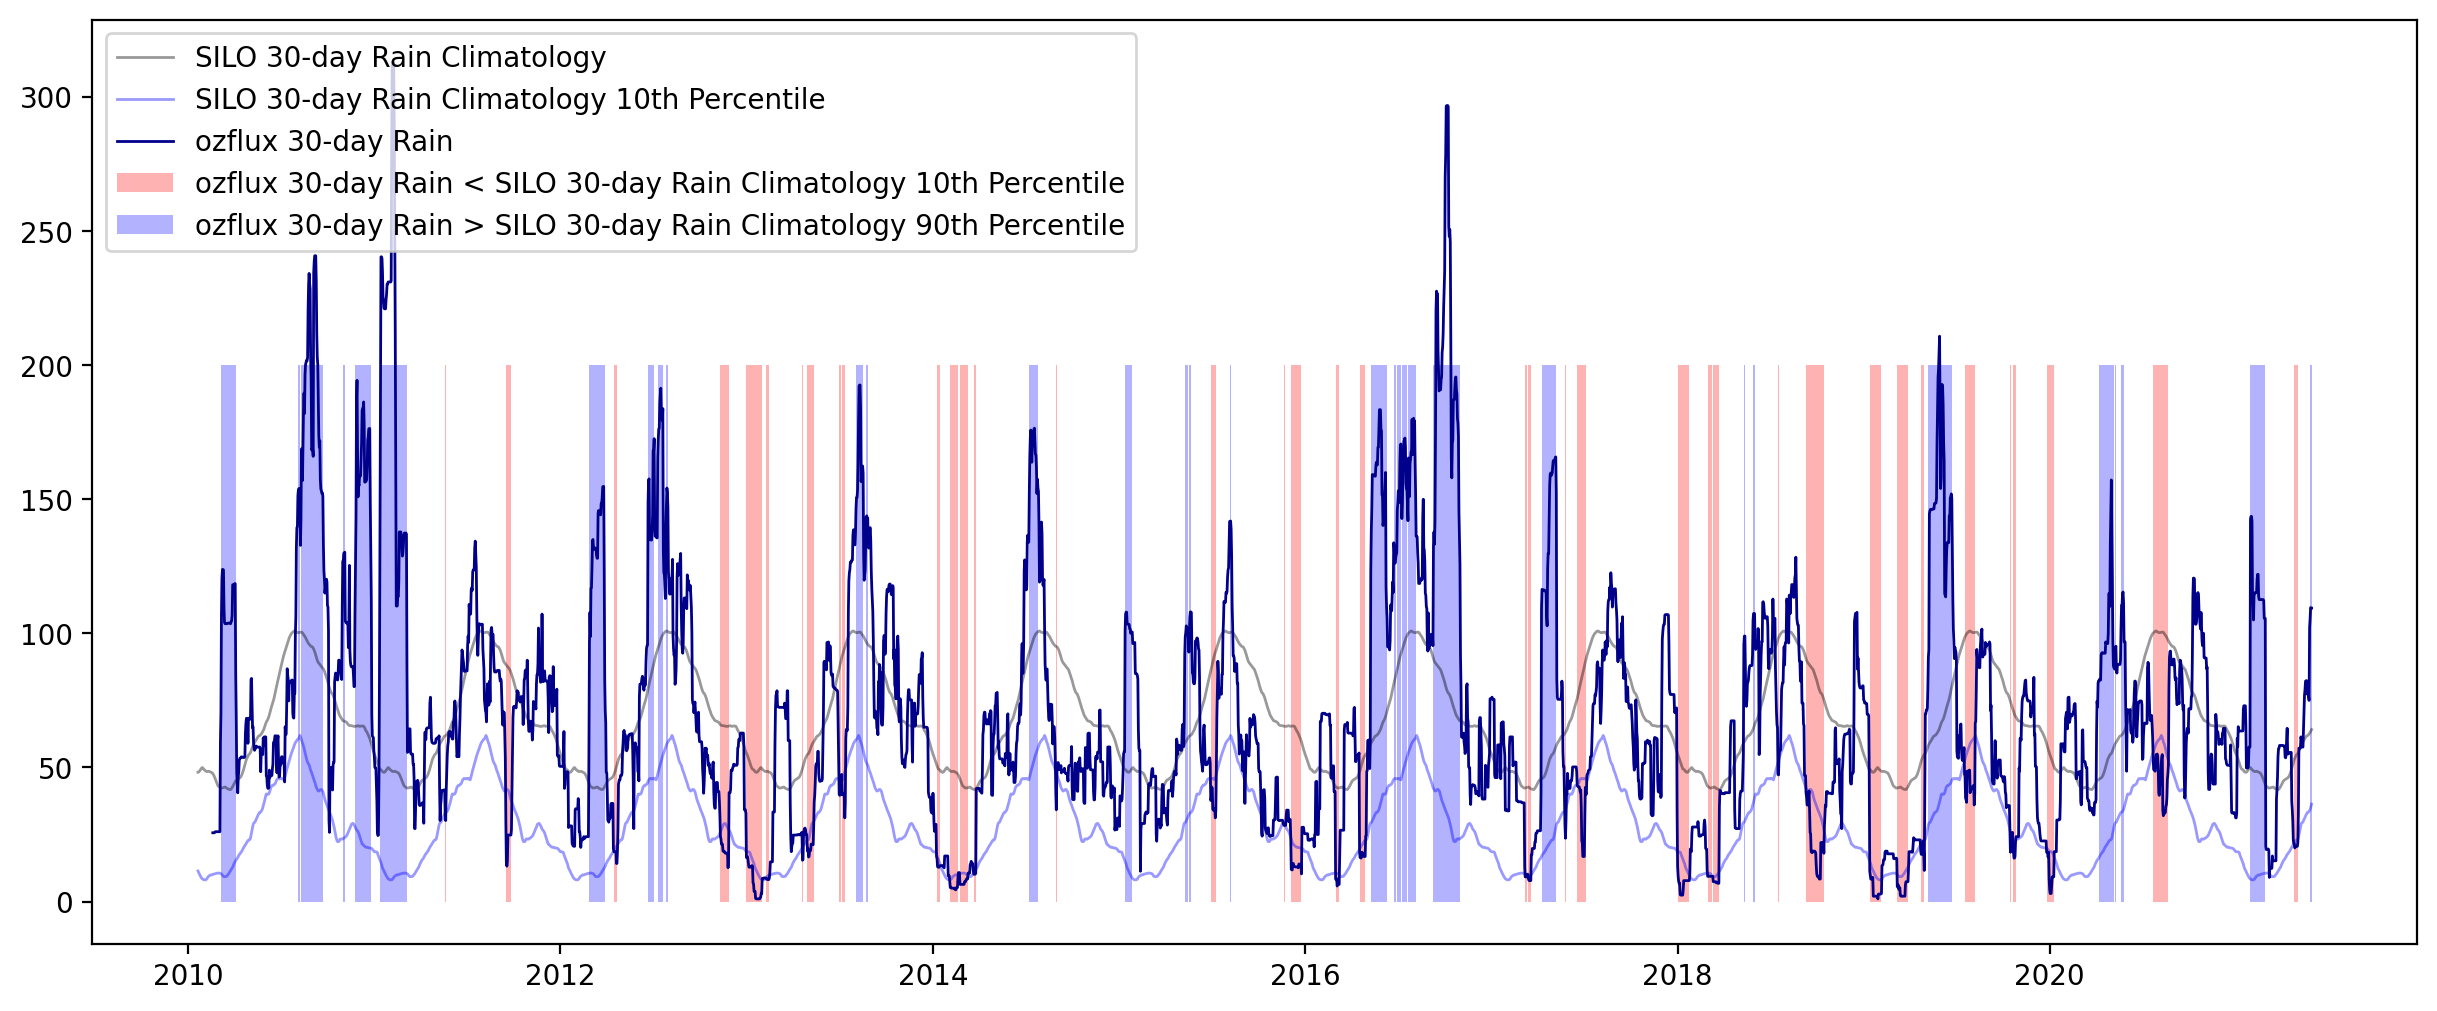

In [176]:
fig, ax = plt.subplots(figsize=(15, 6), dpi=200)
ax.plot(df_merged.index, df_merged['rain_30dayTot_clim'],linewidth=1,color='black', alpha=0.4 ,label='SILO 30-day Rain Climatology')
ax.plot(df_merged.index, df_merged['rain_30dayTot_p10'],linewidth=1,color='blue', alpha=0.4 ,label='SILO 30-day Rain Climatology 10th Percentile')
ax.plot(df_merged.index, df_merged['rain_30dayTot'],linewidth=1,color='darkblue', label='ozflux 30-day Rain')

ymax = 200  # height for shading
ax.fill_between(
    df_merged.index, 0, ymax,
    where=df_merged['drought'],
    step="post",
    color='red',
    alpha=0.3,
    linewidth=0,
    label='ozflux 30-day Rain < SILO 30-day Rain Climatology 10th Percentile'
)
ax.fill_between(
    df_merged.index, 0, ymax,
    where=df_merged['excess'],
    step="post",
    color='blue',
    alpha=0.3,
    linewidth=0,
    label='ozflux 30-day Rain > SILO 30-day Rain Climatology 90th Percentile'
)

ax.legend()

## 90 day drought

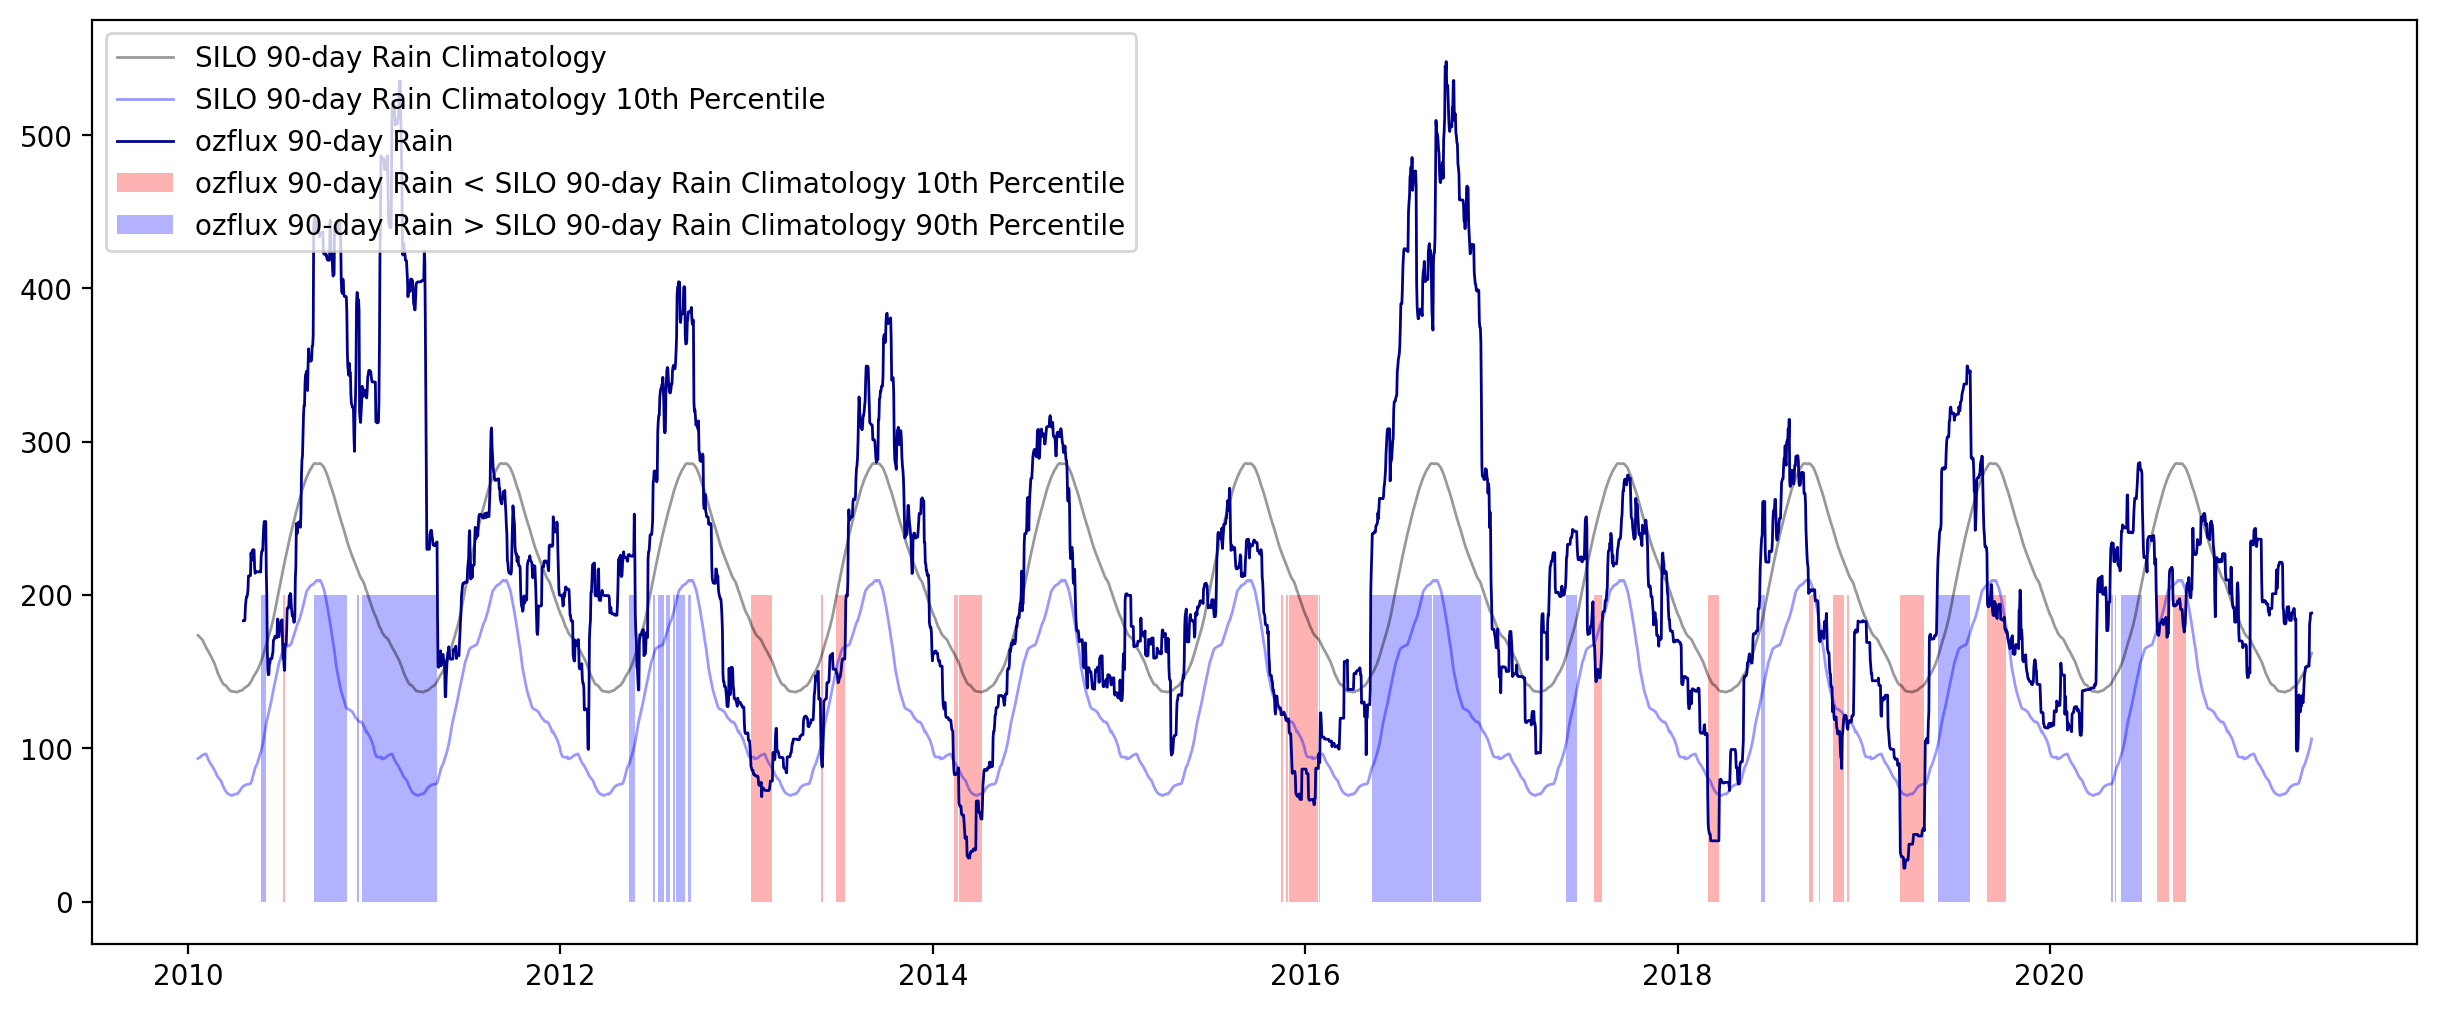

In [216]:
fig, ax = plt.subplots(figsize=(15, 6), dpi=200)
ax.plot(df_merged.index, df_merged['rain_90dayTot_clim'],linewidth=1,color='black', alpha=0.4 ,label='SILO 90-day Rain Climatology')
ax.plot(df_merged.index, df_merged['rain_90dayTot_p10'],linewidth=1,color='blue', alpha=0.4 ,label='SILO 90-day Rain Climatology 10th Percentile')
ax.plot(df_merged.index, df_merged['rain_90dayTot'],linewidth=1,color='darkblue', label='ozflux 90-day Rain')

ymax = 200  # height for shading
ax.fill_between(
    df_merged.index, 0, ymax,
    where=df_merged['drought_90'],
    step="post",
    color='red',
    alpha=0.3,
    linewidth=0,
    label='ozflux 90-day Rain < SILO 90-day Rain Climatology 10th Percentile'
)
ax.fill_between(
    df_merged.index, 0, ymax,
    where=df_merged['excess_90'],
    step="post",
    color='blue',
    alpha=0.3,
    linewidth=0,
    label='ozflux 90-day Rain > SILO 90-day Rain Climatology 90th Percentile'
)

ax.legend()

## Soil water

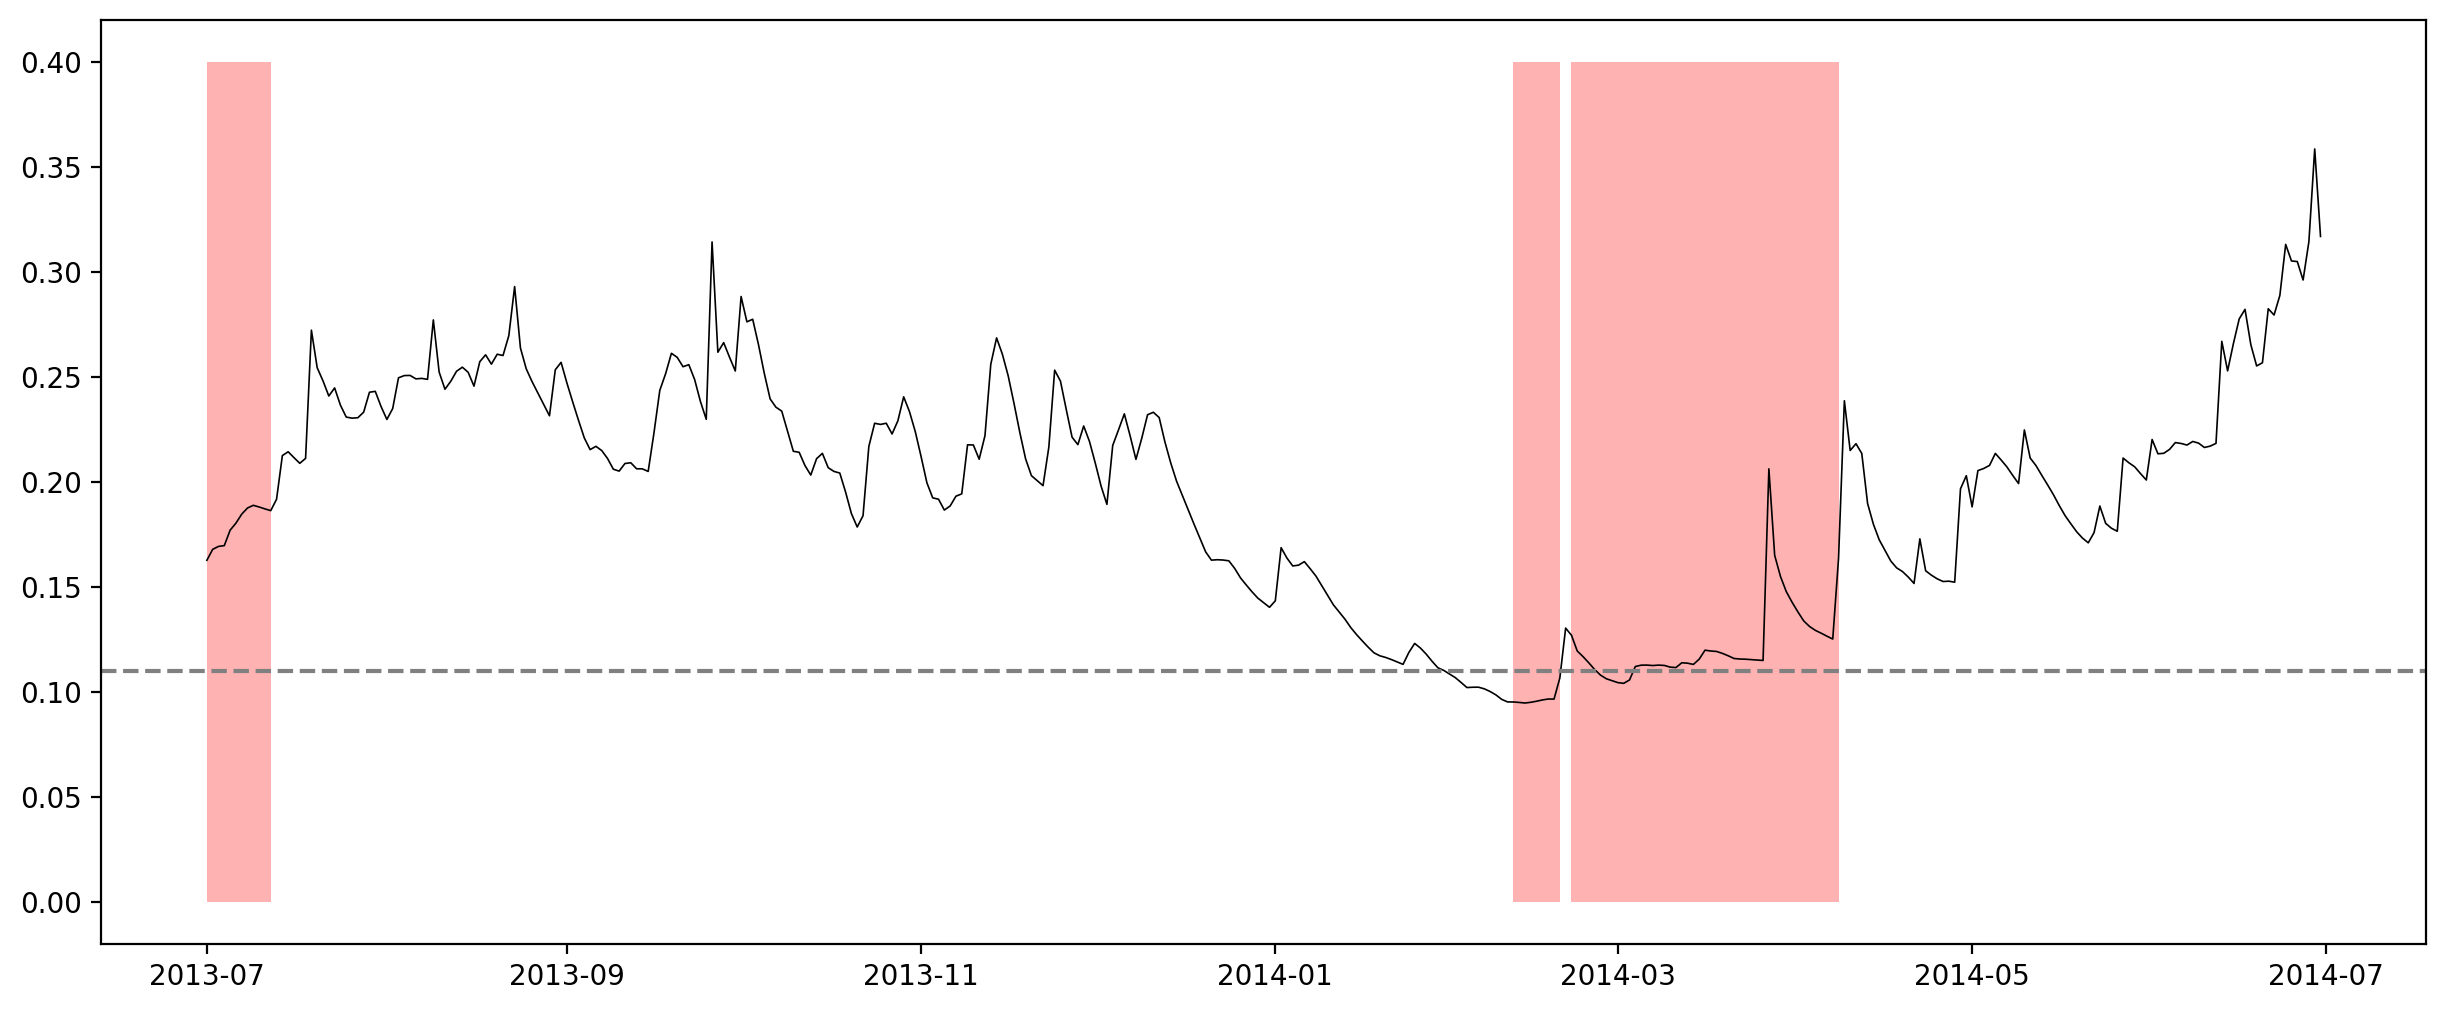

In [218]:
year = 2013

start_date = f"{year}-07-01"
end_date = f"{year+1}-06-30"

df_selected = df_merged.loc[start_date:end_date]

fig, ax = plt.subplots(figsize=(15, 6), dpi=200)

ax.plot(df_selected.index, df_selected['Sws_10_avg'],linewidth=0.6,color='black', alpha=1,label='Soil water content 10cm')
#ax.plot(df_selected.index, df_selected['Sws_95_avg'],linewidth=0.6,color='black', alpha=1,label='Soil water content 95cm', linestyle='--')

ymax = 0.4  # height for shading
ax.fill_between(
    df_selected.index, 0, ymax,
    where=df_selected['drought_90'],
    step="post",
    color='red',
    alpha=0.3,
    linewidth=0,
    label='ozflux 90-day Rain < SILO 90-day Rain Climatology 10th Percentile'
)
ax.fill_between(
    df_selected.index, 0, ymax,
    where=df_selected['excess_90'],
    step="post",
    color='blue',
    alpha=0.3,
    linewidth=0,
    label='ozflux 90-day Rain > SILO 90-day Rain Climatology 90th Percentile'
)

ax.axhline(0.11, color='grey', linestyle='--', label='')

In [202]:
df_merged['Sws_10_avg'].quantile(0.05)

0.11018470479166668